In [1]:
import os

import copy

import pickle

import time

import numpy as np
import pandas as pd

import sys
sys.path.append(r'../')

from utils.WilmanDB import *
from utils.spectrum import *
from utils.methods import skymodel_to_img
from utils.methods import check_mem
import utils.methods as mthd
from utils.functions import in_FoV


from utils.galaxy import RSgen

import matplotlib.pyplot as plt


from astropy import convolution
from astropy.io import fits as fits
import astropy.units as u
from radio_beam import Beam

from scipy.ndimage.interpolation import shift
from scipy.signal import fftconvolve

from joblib import Parallel, delayed


In [2]:
WDB = WilmanDB(dbpath='../data')

Loading data from ../data/wilmandb_rqq.h5.
Finish loading data
Loading data from ../data/wilmandb_fr1.h5.
Finish loading data
Loading data from ../data/wilmandb_fr2.h5.
Finish loading data
Loading data from ../data/wilmandb_sf.h5.
Finish loading data
Loading data from ../data/wilmandb_sb.h5.
Finish loading data


In [3]:
def get_nonzero_values(arr, lim=0):
    indices = np.nonzero(arr > lim)
    return np.transpose((indices[0], indices[1], arr[indices]))

def normalize(arr, flux):
    return arr * flux / np.sum(arr)

In [55]:
class GenSkyModel:
    def __init__(self, PARAMS):
        self.PARAMS = PARAMS
    
    def fr1(self, source, model='GMM', Bmajor=1):
        if model == "GMM":
            skymodel = self.fr1_GMM(source, Bmajor=Bmajor)
        if model == "EllipseModel":
            skymodel = self.fr1_ell_model(source)
        return skymodel
    
    def fr1_ell_model(self, source):
        pass

    def fr1_GMM(self, source, Bmajor=1):
        source_info = self.get_fr1_info(source)
        lobe_minor_beam = source_info['lobe1_minor']
        lobe1_xy = [source_info['lobe1_x'], source_info['lobe1_y']]
        lobe2_xy = [source_info['lobe2_x'], source_info['lobe2_y']]
        core_xy = [source_info['core_x'], source_info['core_y']]
        angle = source_info['lobe1_pa']
        core_major_beam = Bmajor
        core_beam = Beam(core_major_beam*u.arcsec, core_major_beam*u.arcsec, 0*u.deg)
        lobel_beam = Beam(lobe_minor_beam*u.arcsec, lobe_minor_beam*u.arcsec, 0*u.deg)
        a = source_info['lobe1_a']
        b = source_info['lobe1_b']
        pix_scale = self.PARAMS['pix_size']
        core_beam_kern_x_size = int(Bmajor / self.PARAMS['pix_size']) * 2 + 1
        core_beam_kern = core_beam.as_kernel(pix_scale*u.arcsec, x_size=core_beam_kern_x_size, y_size=core_beam_kern_x_size)
        lobe_beam_kern = lobel_beam.as_kernel(pix_scale*u.arcsec, x_size=int(b)*4+1, y_size=int(b)*4+1)
        padding_x = int(np.max([lobe_beam_kern.array.shape[0] / 2, core_beam_kern.array.shape[0]]))
        padding_y = int(np.max([lobe_beam_kern.array.shape[1] / 2, core_beam_kern.array.shape[1]]))
        int_lobe1_x, int_lobe1_y, t_lobe1, v_lobe1 = self.jet_radial_profile(lobe1_xy, a, angle)
        int_lobe2_x, int_lobe2_y, t_lobe2, v_lobe2 = self.jet_radial_profile(lobe2_xy, a, angle)
        xmin = np.min([int_lobe1_x.min(), int_lobe2_x.min()])
        ymin = np.min([int_lobe1_y.min(), int_lobe2_y.min()])
        int_lobe1_x_shifted = np.rint(int_lobe1_x -  xmin)
        int_lobe1_y_shifted = np.rint(int_lobe1_y - ymin)
        int_lobe2_x_shifted = np.rint(int_lobe2_x - xmin)
        int_lobe2_y_shifted = np.rint(int_lobe2_y - ymin)
        core_x_shifted = core_xy[0] - xmin
        core_y_shifted = core_xy[1] - ymin
        img_h = int(np.max([int_lobe1_x_shifted.max(), int_lobe2_x_shifted.max()]) + 1)
        img_w = int(np.max([int_lobe1_y_shifted.max(), int_lobe2_y_shifted.max()]) + 1)
        img = np.zeros([img_h, img_w])
        img = np.pad(img, [(padding_x, padding_x), (padding_y, padding_y)], mode='constant', constant_values=0)
        temp_core = img.copy()
        core_x_shifted = int(np.around(core_x_shifted + padding_x))
        core_y_shifted = int(np.around(core_y_shifted + padding_y))
        int_lobe1_x_shifted += padding_x
        int_lobe1_y_shifted += padding_y
        int_lobe2_x_shifted += padding_x
        int_lobe2_y_shifted += padding_y
        temp_core[core_x_shifted, core_y_shifted] = source_info['core_i_151']
        temp_lobe1 = img.copy()
        temp_lobe1[int_lobe1_x_shifted.astype(int), int_lobe1_y_shifted.astype(int)] = v_lobe1 * source_info['lobe1_i_151']
        temp_lobe2 = img.copy()
        temp_lobe2[int_lobe2_x_shifted.astype(int), int_lobe2_y_shifted.astype(int)] = v_lobe2 * source_info['lobe2_i_151']
        temp_core = convolution.convolve(temp_core, core_beam_kern.array, normalize_kernel=True)
        #temp_core = fftconvolve(temp_core, core_beam_kern.array, mode='same')
        temp_core[temp_core<1e-15] = 0
        temp_core = normalize(temp_core, source_info['core_i_151'])
        temp_core_nonzeros = get_nonzero_values(temp_core)
        temp_core_nonzeros[:, 2] = temp_core_nonzeros[:, 2] * source_info['core_i_151'] / np.sum(temp_core_nonzeros[:, 2])

        source_info['core_data'] = temp_core_nonzeros
        temp_lobe1 = convolution.convolve(temp_lobe1, lobe_beam_kern.array, normalize_kernel=True)
        temp_lobe1[temp_lobe1<1e-15] = 0
        temp_lobe1 = normalize(temp_lobe1, source_info['lobe1_i_151'])
        #temp_lobe1 = fftconvolve(temp_lobe1, lobe_beam_kern.array, mode='same')
        
        temp_lobe1_nonzeros = get_nonzero_values(temp_lobe1)
        temp_lobe1_nonzeros[:, 2] = temp_lobe1_nonzeros[:, 2] * source_info['lobe1_i_151'] / np.sum(temp_lobe1_nonzeros[:, 2])

        source_info['lobe1_data'] = temp_lobe1_nonzeros
        temp_lobe2 = convolution.convolve(temp_lobe2, lobe_beam_kern.array, normalize_kernel=True)
        temp_lobe2[temp_lobe2<1e-15] = 0
        temp_lobe2 = normalize(temp_lobe2, source_info['lobe2_i_151'])
        #temp_lobe2 = fftconvolve(temp_lobe2, lobe_beam_kern.array, mode='same')
        temp_lobe2_nonzeros = get_nonzero_values(temp_lobe2)
        temp_lobe2_nonzeros[:, 2] = temp_lobe2_nonzeros[:, 2] * source_info['lobe2_i_151'] / np.sum(temp_lobe2_nonzeros[:, 2])

        source_info['lobe2_data'] = temp_lobe2_nonzeros
        model = temp_core + temp_lobe1 + temp_lobe2
        source_info['data'] = get_nonzero_values(model)
        source_info['type'] = 'FR1' 
        source_info['relative_x'] = core_x_shifted
        source_info['relative_y'] = core_y_shifted
        x_shifted = core_xy[0] - core_x_shifted
        y_shifted = core_xy[1] - core_y_shifted
        if not in_FoV(0, self.PARAMS['img_size'], temp_core_nonzeros[:, 0]+x_shifted, temp_lobe1_nonzeros[:, 0]+x_shifted, temp_lobe2_nonzeros[:, 0]+x_shifted, temp_core_nonzeros[:, 1]+y_shifted, temp_lobe1_nonzeros[:, 1]+y_shifted, temp_lobe2_nonzeros[:, 1]+y_shifted):
            return None
        return source_info
    
    def fr2(self, source, model='GMM', Bmajor=1):
        if model == "GMM":
            skymodel = self.fr2_GMM(source, Bmajor=Bmajor)
        if model == "EllipseModel":
            skymodel = self.fr2_ell_model(source)
        return skymodel
    
    def fr2_ell_model(self, source):
        pass
    
    def fr2_GMM(self, source, Bmajor=1):
        source_info = self.get_fr2_info(source)
        lobe_minor_beam = source_info['lobe1_minor']
        lobe1_xy = [source_info['lobe1_x'], source_info['lobe1_y']]
        lobe2_xy = [source_info['lobe2_x'], source_info['lobe2_y']]
        core_xy = [source_info['core_x'], source_info['core_y']]
        hp1_xy = [source_info['hp1_x'], source_info['hp1_y']]
        hp2_xy = [source_info['hp2_x'], source_info['hp2_y']]
        angle = source_info['lobe1_pa']
        core_major_beam = Bmajor
        core_beam = Beam(core_major_beam*u.arcsec, core_major_beam*u.arcsec, 0*u.deg)
        lobel_beam = Beam(lobe_minor_beam*u.arcsec, lobe_minor_beam*u.arcsec, 0*u.deg)
        a = source_info['lobe1_a']
        b = source_info['lobe1_b']
        pix_scale = self.PARAMS['pix_size']
        core_beam_kern_x_size = int(Bmajor / self.PARAMS['pix_size']) * 2 + 1
        core_beam_kern = core_beam.as_kernel(pix_scale*u.arcsec, x_size=core_beam_kern_x_size, y_size=core_beam_kern_x_size)
        lobe_beam_kern = lobel_beam.as_kernel(pix_scale*u.arcsec, x_size=int(b)*4+1, y_size=int(b)*4+1)
        padding_x = int(lobe_beam_kern.array.shape[0] / 2)
        padding_y = int(lobe_beam_kern.array.shape[1] / 2)
        int_lobe1_x, int_lobe1_y, t_lobe1, v_lobe1 = self.jet_radial_profile(lobe1_xy, a, angle)
        int_lobe2_x, int_lobe2_y, t_lobe2, v_lobe2 = self.jet_radial_profile(lobe2_xy, a, angle)
        xmin = np.min([int_lobe1_x.min(), int_lobe2_x.min(), hp1_xy[0], hp2_xy[0]])
        ymin = np.min([int_lobe1_y.min(), int_lobe2_y.min(), hp1_xy[1], hp2_xy[1]])
        int_lobe1_x_shifted = np.rint(int_lobe1_x -  xmin)
        int_lobe1_y_shifted = np.rint(int_lobe1_y - ymin)
        int_lobe2_x_shifted = np.rint(int_lobe2_x - xmin)
        int_lobe2_y_shifted = np.rint(int_lobe2_y - ymin)
        core_x_shifted = np.rint(core_xy[0] - xmin)
        core_y_shifted = np.rint(core_xy[1] - ymin)
        hp1_x_shifted = np.rint(hp1_xy[0] - xmin)
        hp1_y_shifted = np.rint(hp1_xy[1] - ymin)
        hp2_x_shifted = np.rint(hp2_xy[0] - xmin)
        hp2_y_shifted = np.rint(hp2_xy[1] - ymin)
        img_h = int(np.max([int_lobe1_x_shifted.max(), int_lobe2_x_shifted.max(), hp1_x_shifted, hp2_x_shifted]) + 1)
        img_w = int(np.max([int_lobe1_y_shifted.max(), int_lobe2_y_shifted.max(), hp1_y_shifted, hp2_y_shifted]) + 1)
        img = np.zeros([img_h, img_w])
        img = np.pad(img, [(padding_x, padding_x), (padding_y, padding_y)], mode='constant', constant_values=0)
        temp_core = img.copy()
        temp_hp1 = img.copy()
        temp_hp2 = img.copy()
        core_x_shifted = int(np.around(core_x_shifted + padding_x))
        core_y_shifted = int(np.around(core_y_shifted + padding_y))
        hp1_x_shifted = int(np.around(hp1_x_shifted + padding_x))
        hp1_y_shifted = int(np.around(hp1_y_shifted + padding_y))
        hp2_x_shifted = int(np.around(hp2_x_shifted + padding_x))
        hp2_y_shifted = int(np.around(hp2_y_shifted + padding_y))
        int_lobe1_x_shifted += padding_x
        int_lobe1_y_shifted += padding_y
        int_lobe2_x_shifted += padding_x
        int_lobe2_y_shifted += padding_y
        temp_core[core_x_shifted, core_y_shifted] = source_info['core_i_151']
        temp_hp1[hp1_x_shifted, hp1_y_shifted] = source_info['hotspot1_i_151']
        temp_hp2[hp2_x_shifted, hp2_y_shifted] = source_info['hotspot2_i_151']
        temp_lobe1 = img.copy()
        temp_lobe1[int_lobe1_x_shifted.astype(int), int_lobe1_y_shifted.astype(int)] = v_lobe1 * source_info['lobe1_i_151']
        temp_lobe2 = img.copy()
        temp_lobe2[int_lobe2_x_shifted.astype(int), int_lobe2_y_shifted.astype(int)] = v_lobe2 * source_info['lobe2_i_151']
        temp_core = convolution.convolve(temp_core, core_beam_kern.array, normalize_kernel=True)
        temp_core[temp_core<1e-15] = 0
        temp_core = normalize(temp_core, source_info['core_i_151'])
        temp_core_nonzeros = get_nonzero_values(temp_core)
        #temp_core_nonzeros[:, 2] = temp_core_nonzeros[:, 2] * source_info['core_i_151'] / np.sum(temp_core_nonzeros[:, 2])
        source_info['core_data'] = temp_core_nonzeros
        
        temp_hp1 = convolution.convolve(temp_hp1, core_beam_kern.array, normalize_kernel=True)
        temp_hp1[temp_hp1<1e-15] = 0
        temp_hp1 = normalize(temp_hp1, source_info['hotspot1_i_151'])
        temp_hp1_nonzeros = get_nonzero_values(temp_hp1)
        #temp_hp1_nonzeros[:, 2] = temp_hp1_nonzeros[:, 2] * source_info['hotspot1_i_151'] / np.sum(temp_hp1_nonzeros[:, 2])
        source_info['hotspot1_data'] = temp_hp1_nonzeros
        
        temp_hp2 = convolution.convolve(temp_hp2, core_beam_kern.array, normalize_kernel=True)
        temp_hp2[temp_hp2<1e-15] = 0
        temp_hp2 = normalize(temp_hp2, source_info['hotspot2_i_151'])
        temp_hp2_nonzeros = get_nonzero_values(temp_hp2)
        #temp_hp2_nonzeros[:, 2] = temp_hp2_nonzeros[:, 2] * source_info['hotspot2_i_151'] / np.sum(temp_hp2_nonzeros[:, 2])
        source_info['hotspot2_data'] = temp_hp2_nonzeros
        
        temp_lobe1 = convolution.convolve(temp_lobe1, lobe_beam_kern.array, normalize_kernel=True)
        temp_lobe1[temp_lobe1<1e-15] = 0
        temp_lobe1 = normalize(temp_lobe1, source_info['lobe1_i_151'])
        temp_lobe1_nonzeros = get_nonzero_values(temp_lobe1)
        #temp_lobe1_nonzeros[:, 2] = temp_lobe1_nonzeros[:, 2] * source_info['lobe1_i_151'] / np.sum(temp_lobe1_nonzeros[:, 2])
        source_info['lobe1_data'] = temp_lobe1_nonzeros
        
        temp_lobe2 = convolution.convolve(temp_lobe2, lobe_beam_kern.array, normalize_kernel=True)
        temp_lobe2[temp_lobe2<1e-15] = 0
        temp_lobe2 = normalize(temp_lobe2, source_info['lobe2_i_151'])
        temp_lobe2_nonzeros = get_nonzero_values(temp_lobe2)
        #temp_lobe2_nonzeros[:, 2] = temp_lobe2_nonzeros[:, 2] * source_info['lobe2_i_151'] / np.sum(temp_lobe2_nonzeros[:, 2])
        source_info['lobe2_data'] = temp_lobe2_nonzeros
        
        source_info['type'] = 'FR2'
        source_info['relative_x'] = core_x_shifted
        source_info['relative_y'] = core_y_shifted
        x_shifted = core_xy[0] - core_x_shifted
        y_shifted = core_xy[1] - core_y_shifted
        if not in_FoV(0, self.PARAMS['img_size'], temp_core_nonzeros[:, 0]+x_shifted, source_info['hotspot1_data'][:, 0]+x_shifted, source_info['hotspot2_data'][:, 0]+x_shifted, source_info['lobe1_data'][:, 0]+x_shifted, source_info['lobe2_data'][:, 0]+x_shifted, temp_core_nonzeros[:, 1]+y_shifted, source_info['hotspot1_data'][:, 1]+y_shifted, source_info['hotspot2_data'][:, 1]+y_shifted, source_info['lobe1_data'][:, 1]+y_shifted, source_info['lobe2_data'][:, 1]+y_shifted):
            return None
        model = temp_core + temp_hp1 + temp_hp2 + temp_lobe1 + temp_lobe2
        source_info['data'] = get_nonzero_values(model)
        return source_info
                
    def get_fr1_info(self, source):
        source_info = {}
        index = source.index
        source_info['index'] = source.index
        source_info['galaxy'] = source.loc[index[0]].galaxy
        source_info['agntype'] = source.loc[index[0]].agntype
        source_info['i_151_tot'] = source.loc[index[0]].i_151_tot
        source_info['redshift'] = source.loc[index[0]].redshift
        #core
        source_info['core_structure'] = source.loc[index[0]].structure
        source_info['core_ra'] = source.loc[index[0]].ra - self.PARAMS['ra_min']
        source_info['core_dec'] = source.loc[index[0]].dec - self.PARAMS['dec_min']
        source_info['core_i_151'] = source.loc[index[0]].i_151_flux
        #lobel
        source_info['lobe1_structure'] = source.loc[index[1]].structure
        source_info['lobe1_ra'] = source.loc[index[1]].ra - self.PARAMS['ra_min']
        source_info['lobe1_dec'] = source.loc[index[1]].dec - self.PARAMS['dec_min']
        source_info['lobe1_i_151'] = source.loc[index[1]].i_151_flux
        source_info['lobe1_pa'] = source.loc[index[1]].pa
        source_info['lobe1_major'] = source.loc[index[1], 'major_axis']
        source_info['lobe1_minor'] = source.loc[index[1], 'minor_axis']
        #lobe2
        source_info['lobe2_structure'] = source.loc[index[2]].structure
        source_info['lobe2_ra'] = source.loc[index[2]].ra - self.PARAMS['ra_min']
        source_info['lobe2_dec'] = source.loc[index[2]].dec - self.PARAMS['dec_min']
        source_info['lobe2_i_151'] = source.loc[index[2]].i_151_flux
        source_info['lobe2_pa'] = source.loc[index[2]].pa
        source_info['lobe2_major'] = source.loc[index[2], 'major_axis']
        source_info['lobe2_minor'] = source.loc[index[2], 'minor_axis']
        core_x, lobe1_x, lobe2_x = (source.ra - self.PARAMS['ra_min']) / self.PARAMS['pix_deg']
        core_y, lobe1_y, lobe2_y = (source.dec - self.PARAMS['dec_min']) / self.PARAMS['pix_deg']
        source_info['core_x'] = core_x
        source_info['core_y'] = core_y
        source_info['lobe1_x'] = lobe1_x
        source_info['lobe1_y'] = lobe1_y
        source_info['lobe2_x'] = lobe2_x
        source_info['lobe2_y'] = lobe2_y   
        a1 = 0.5 * source_info['lobe1_major'] / self.PARAMS['pix_size']
        b1 = 0.5 * source_info['lobe1_minor'] / self.PARAMS['pix_size']
        source_info['lobe1_a'] = a1
        source_info['lobe1_b'] = b1
        a2 = 0.5 * source_info['lobe2_major'] / self.PARAMS['pix_size']
        b2 = 0.5 * source_info['lobe2_minor'] / self.PARAMS['pix_size']
        source_info['lobe2_a'] = a2
        source_info['lobe2_b'] = b2
        return source_info
        
    def get_fr2_info(self, source):
        source_info = {}
        index = source.index
        source_info['index'] = source.index
        source_info['galaxy'] = source.loc[index[0]].galaxy
        source_info['agntype'] = source.loc[index[0]].agntype
        source_info['i_151_tot'] = source.loc[index[0]].i_151_tot
        source_info['redshift'] = source.loc[index[0]].redshift
        #core
        source_info['core_structure'] = source.loc[index[0]].structure
        source_info['core_ra'] = source.loc[index[0]].ra - self.PARAMS['ra_min']
        source_info['core_dec'] = source.loc[index[0]].dec - self.PARAMS['dec_min']
        source_info['core_i_151'] = source.loc[index[0]].i_151_flux
        #lobel
        source_info['lobe1_structure'] = source.loc[index[1]].structure
        source_info['lobe1_ra'] = source.loc[index[1]].ra - self.PARAMS['ra_min']
        source_info['lobe1_dec'] = source.loc[index[1]].dec - self.PARAMS['dec_min']
        source_info['lobe1_i_151'] = source.loc[index[1]].i_151_flux
        source_info['lobe1_pa'] = source.loc[index[1]].pa
        source_info['lobe1_major'] = source.loc[index[1], 'major_axis']
        source_info['lobe1_minor'] = source.loc[index[1], 'minor_axis']
        #lobe2
        source_info['lobe2_structure'] = source.loc[index[2]].structure
        source_info['lobe2_ra'] = source.loc[index[2]].ra - self.PARAMS['ra_min']
        source_info['lobe2_dec'] = source.loc[index[2]].dec - self.PARAMS['dec_min']
        source_info['lobe2_i_151'] = source.loc[index[2]].i_151_flux
        source_info['lobe2_pa'] = source.loc[index[2]].pa
        source_info['lobe2_major'] = source.loc[index[2], 'major_axis']
        source_info['lobe2_minor'] = source.loc[index[2], 'minor_axis']
        #hotspot1
        source_info['hotspot1_ra'] = source.loc[index[3]].ra - self.PARAMS['ra_min']
        source_info['hotspot1_dec'] = source.loc[index[3]].dec - self.PARAMS['dec_min']
        source_info['hotspot1_i_151'] = source.loc[index[3]].i_151_flux
        source_info['hotspot1_structure'] = source.loc[index[3]].structure
        #hotspot2
        source_info['hotspot2_ra'] = source.loc[index[4]].ra - self.PARAMS['ra_min']
        source_info['hotspot2_dec'] = source.loc[index[4]].dec - self.PARAMS['dec_min']
        source_info['hotspot2_i_151'] = source.loc[index[4]].i_151_flux
        source_info['hotspot2_structure'] = source.loc[index[4]].structure    

        core_x, lobe1_x, lobe2_x, hp1_x, hp2_x = (source.ra - self.PARAMS['ra_min']) / self.PARAMS['pix_deg']
        core_y, lobe1_y, lobe2_y, hp1_y, hp2_y = (source.dec - self.PARAMS['dec_min']) / self.PARAMS['pix_deg']
        
        source_info['core_x'] = core_x
        source_info['core_y'] = core_y
        source_info['lobe1_x'] = lobe1_x
        source_info['lobe1_y'] = lobe1_y
        source_info['lobe2_x'] = lobe2_x
        source_info['lobe2_y'] = lobe2_y   
        source_info['hp1_x'] = hp1_x
        source_info['hp1_y'] = hp1_y
        source_info['hp2_x'] = hp2_x
        source_info['hp2_y'] = hp2_y
        
        a1 = 0.5 * source_info['lobe1_major'] / self.PARAMS['pix_size']
        b1 = 0.5 * source_info['lobe1_minor'] / self.PARAMS['pix_size']
        source_info['lobe1_a'] = a1
        source_info['lobe1_b'] = b1
        a2 = 0.5 * source_info['lobe2_major'] / self.PARAMS['pix_size']
        b2 = 0.5 * source_info['lobe2_minor'] / self.PARAMS['pix_size']
        source_info['lobe2_a'] = a2
        source_info['lobe2_b'] = b2
        return source_info
            
    def sfsb(self, source, model='GMM', Bmajor=1):
        if model == "GMM":
            skymodel = self.sfsb_GMM(source, Bmajor=Bmajor)
        if model == "EllipseModel":
            skymodel = self.sfsb_ell_model(source)
        return skymodel
        
    
    def sfsb_ell_model(self, source):
        """
        Star-formation / starburst galaxies

        """  
        source_info = self.get_sfsb_info(source)
        x = source_info['x']
        y = source_info['y']
        if in_FoV(0, self.PARAMS['img_size'], x, y):
            a = 0.5 * source_info['major'] / self.PARAMS['pix_size']
            b = 0.5 * source_info['minor'] / self.PARAMS['pix_size']
            xmin = int(np.round(x - a))
            xmax = int(np.round(x + a))
            ymin = int(np.round(y - b))
            ymax = int(np.round(y + b))
            xc = x - xmin
            yc = y - ymin
            pix_info = []
            ellipse = mthd.draw_ellipse([2*xc, 2*yc], [xc,yc], a, b, source_info['pa'])
            area = np.sum(ellipse)
            if area == 0:
                area = 1
            if area == 1:
                pix = (xc, yc, source_info['i_151'])
                pix_info.append(pix)
                source_info['sim_freq'] = 151
                source_info['relative_x'] = x
                source_info['relative_y'] = x
                source_info['data'] = np.array(pix_info)
                if source_info['sftype'] == 4:
                    source_info['type'] = 'SF'
                if source_info['sftype'] == 5:
                    source_info['type'] = 'SB'
            else:
                flux_pix = source_info['i_151'] / area
                ellipse = ellipse * flux_pix
                ellipse_nonzero_values = get_nonzero_values(ellipse)
                x_min = np.min(ellipse_nonzero_values[:, 0])
                y_min = np.min(ellipse_nonzero_values[:, 1])
                ellipse_nonzero_values[:, 0] -= x_min
                ellipse_nonzero_values[:, 1] -= y_min
                source_info['data'] = ellipse_nonzero_values
                source_info['relative_x'] = xc - x_min
                source_info['relative_y'] = yc - y_min
                x_shifted = x - source_info['relative_x']
                y_shifted = y - source_info['relative_x']
                if in_FoV(0, self.PARAMS['img_size'], ellipse_nonzero_values[:, 0]+x_shifted, ellipse_nonzero_values[:, 1]+y_shifted):
                    if source_info['sftype'] == 4:
                        source_info['type'] = 'SF'
                    if source_info['sftype'] == 5:
                        source_info['type'] = 'SB'
                else:
                    return None
        else:
            return None
        return source_info
        
    def sfsb_GMM(self, source, Bmajor=1):
        """
        Star-formation / starburst galaxies

        """  
        source_info = self.get_sfsb_info(source)
        x = source_info['x']
        y = source_info['y']
        if in_FoV(0, self.PARAMS['img_size'], x, y):
            a = 0.5 * source_info['major'] / self.PARAMS['pix_size']
            b = 0.5 * source_info['minor'] / self.PARAMS['pix_size']
            xmin = int(np.round(x - a))
            xmax = int(np.round(x + a))
            ymin = int(np.round(y - b))
            ymax = int(np.round(y + b))
            xc = x - xmin
            yc = y - ymin
            pix_info = []
            if xc == 0:
                xc = 1
            if yc == 0:
                yc = 1
            ellipse = mthd.draw_ellipse([2*xc, 2*yc], [xc,yc], a, b, source_info['pa'])
            core_beam = Beam(Bmajor*u.arcsec, Bmajor*u.arcsec, 0*u.deg)
            core_beam_kern_x_size = int(Bmajor / self.PARAMS['pix_size']) * 2 + 1
            core_beam_kern = core_beam.as_kernel(self.PARAMS['pix_size']*u.arcsec, x_size=core_beam_kern_x_size,y_size=core_beam_kern_x_size)
            padding_x = int(core_beam_kern.shape[0] / 2)
            padding_y = int(core_beam_kern.shape[1] / 2)
            area = np.sum(ellipse)
            if area == 0:
                area = 1
            if area == 1:
                core_x_shifted = 0
                core_y_shifted = 0
                temp_core = np.zeros([1, 1])
                temp_core = np.pad(temp_core, [(padding_x, padding_x), (padding_y, padding_y)], mode='constant', constant_values=0)
                core_x_shifted = int(np.around(core_x_shifted + padding_x))
                core_y_shifted = int(np.around(core_y_shifted + padding_y))
                temp_core[core_x_shifted, core_y_shifted] = source_info['i_151']
                temp_core = fftconvolve(temp_core, core_beam_kern.array, mode='same')
                #temp_core = convolution.convolve(temp_core, core_beam_kern.array, normalize_kernel=True)
                temp_core[temp_core<1e-15] = 0
                temp_core = normalize(temp_core, source_info['i_151'])
                temp_core_nonzeros = get_nonzero_values(temp_core)
                source_info['relative_x'] = core_x_shifted
                source_info['relative_y'] = core_y_shifted
                source_info['data'] = temp_core_nonzeros
                source_info['sim_freq'] = 151
                x_shifted = x - source_info['relative_x']
                y_shifted = y - source_info['relative_x']
                if source_info['sftype'] == 4:
                    source_info['type'] = 'SF'
                if source_info['sftype'] == 5:
                    source_info['type'] = 'SB'
                if not in_FoV(0, self.PARAMS['img_size'], temp_core_nonzeros[:, 0]+x_shifted, temp_core_nonzeros[:, 1]+y_shifted):
                    return None
            else:
                flux_pix = source_info['i_151'] / area
                ellipse = ellipse * flux_pix
                ellipse_padded = np.pad(ellipse, [(padding_x, padding_x), (padding_y, padding_y)], mode='constant', constant_values=0)
                #ellipse_conv = convolution.convolve(ellipse_padded, core_beam_kern.array, normalize_kernel=True)
                ellipse_conv = fftconvolve(ellipse_padded, core_beam_kern.array, mode='same')
                ellipse_conv[ellipse_conv<1e-15] = 0
                ellipse_conv = normalize(ellipse_conv, source_info['i_151'])
                ellipse_conv_nonzeros = get_nonzero_values(ellipse_conv)
                x_min = np.min(ellipse_conv_nonzeros[:, 0])
                y_min = np.min(ellipse_conv_nonzeros[:, 1])
                ellipse_conv_nonzeros[:, 0] -= x_min
                ellipse_conv_nonzeros[:, 1] -= y_min
                source_info['relative_x'] = xc + padding_x - x_min
                source_info['relative_y'] = yc + padding_y - y_min
                source_info['data'] = ellipse_conv_nonzeros
                source_info['sim_freq'] = 151
                x_shifted = x - source_info['relative_x']
                y_shifted = y - source_info['relative_x']
                if in_FoV(0, self.PARAMS['img_size'], ellipse_conv_nonzeros[:, 0]+x_shifted, ellipse_conv_nonzeros[:, 1]+y_shifted):
                    if source_info['sftype'] == 4:
                        source_info['type'] = 'SF'
                    if source_info['sftype'] == 5:
                        source_info['type'] = 'SB'
                else:
                    return None
        else:
            return None
        return source_info
        
    def get_sfsb_info(self, source):
        source_info = {}
        source_info['index'] = source.Index
        gindex = source.Index
        source_info['galaxy'] = source.galaxy # galaxy number
        source_info['sftype'] = source.sftype + 3 # galaxy type;
        source_info['i_151_tot'] = source.i_151_tot
        source_info['redshift'] = source.redshift
        source_info['structure'] = source.structure
        source_info['ra'] = source.ra - self.PARAMS['ra_min']
        source_info['dec'] = source.dec - self.PARAMS['dec_min']
        source_info['i_151'] = source.i_151_flux
        source_info['pa'] = source.pa
        source_info['major'] = source.major_axis
        source_info['minor'] = source.minor_axis
        source_info['x'] = int(source_info['ra'] / self.PARAMS['pix_deg'])
        source_info['y'] = int(source_info['dec'] / self.PARAMS['pix_deg'])
        return source_info
        
    
    def rq(self, source, model='GMM', Bmajor=1):
        if model == "GMM":
            skymodel = self.rq_GMM(source, Bmajor=Bmajor)
        if model == "PointModel":
            skymodel = self.rq_point_model(source)
        return skymodel
    
    def rq_point_model(self, source):
        """
        Radio Quiet galaxies.

        """
        source_info = self.get_rq_info(source)
        source_info['type'] = 'RQ'
        x = source_info['x']
        y = source_info['y']
        if not in_FoV(0, self.PARAMS['img_size'], x, y):
            return None
        pix_info = [(0, 0, source_info['i_151'])]
        source_info['data'] = np.array(pix_info)
        source_info['sim_freq'] = 151
        source_info['relative_x'] = 0
        source_info['relative_y'] = 0
        return source_info
    
    def rq_GMM(self, source, Bmajor=1):
        """
        Radio Quiet galaxies.

        """  
        source_info = self.get_rq_info(source)
        x = source_info['x']
        y = source_info['y']
        core_x_shifted = 0
        core_y_shifted = 0
        core_beam = Beam(Bmajor*u.arcsec, Bmajor*u.arcsec, 0*u.deg)
        core_beam_kern_x_size = int(Bmajor / self.PARAMS['pix_size']) * 2 + 1
        core_beam_kern = core_beam.as_kernel(self.PARAMS['pix_size']*u.arcsec, x_size=core_beam_kern_x_size,y_size=core_beam_kern_x_size)
        padding_x = int(core_beam_kern.shape[0] / 2)
        padding_y = int(core_beam_kern.shape[1] / 2)
        temp_core = np.zeros([1, 1])
        temp_core = np.pad(temp_core, [(padding_x, padding_x), (padding_y, padding_y)], mode='constant', constant_values=0)
        core_x_shifted = int(np.around(core_x_shifted + padding_x))
        core_y_shifted = int(np.around(core_y_shifted + padding_y))
        temp_core[core_x_shifted, core_y_shifted] = source_info['i_151']
        temp_core = convolution.convolve(temp_core, core_beam_kern.array, normalize_kernel=True)
        temp_core[temp_core<1e-15] = 0
        temp_core = normalize(temp_core, source_info['i_151'])
        temp_core_nonzeros = get_nonzero_values(temp_core)
        source_info['relative_x'] = core_x_shifted
        source_info['relative_y'] = core_y_shifted
        source_info['data'] = temp_core_nonzeros
        source_info['sim_freq'] = 151
        x_shifted = x - source_info['relative_x']
        y_shifted = y - source_info['relative_x']
        if not in_FoV(0, self.PARAMS['img_size'], temp_core_nonzeros[:, 0]+x_shifted, temp_core_nonzeros[:, 1]+y_shifted):
            return None
        return source_info
    
    def get_rq_info(self, source):
        source_info = {}
        source_info['type'] = 'RQ'
        source_info['index'] = source.index[0]
        gindex = source.index[0]
        source_info['i_151'] = source.loc[gindex, 'i_151_flux']
        source_info['ra'] = source.loc[gindex, 'ra'] - self.PARAMS['ra_min']
        source_info['dec'] = source.loc[gindex, 'dec'] - self.PARAMS['dec_min']
        source_info['redshift'] = source.loc[gindex, 'redshift']
        source_info['galaxy'] = source.loc[gindex, 'galaxy']
        source_info['agntype'] = source.loc[gindex, 'agntype']
        source_info['structure'] = source.loc[gindex, 'structure']
        source_info['i_151_tot'] = source.loc[gindex, 'i_151_tot']
        source_info['x'] = int(source_info['ra'] / self.PARAMS['pix_deg'])
        source_info['y'] = int(source_info['dec'] / self.PARAMS['pix_deg'])
        return source_info
    
    def jet_radial_profile(self, mu, sig, angle):
        a = sig * 2
        t = np.arange(-a, a+1, 1)
        x, y = self.linear_function(mu, t, angle)
        int_x, int_y = np.rint(x), np.rint(y)
        unique_index = abs(int_x[1:] - int_x[:-1]) + abs(int_y[1:] - int_y[:-1])
        unique_index = unique_index.astype(bool)
        unique_index = np.insert(unique_index, 0, values=1, axis=0)
        int_x = int_x[unique_index]
        int_y = int_y[unique_index]
        #new_t = (int_x - mu[0]) ** 2 + (int_y - mu[0]) ** 2
        new_t = t[unique_index]
        flux = 1 / sig /np.sqrt(2 * np.pi) * np.exp(-np.power(new_t - 0, 2.) / (2 * np.power(sig, 2.)))
        flux = flux / np.sum(flux)
        return [int_x, int_y, new_t, flux]
    
    def linear_function(self, center, t, theta):
        x = center[0] + t * np.sin(theta)
        y = center[1] + t * np.cos(theta)
        return [x, y]

In [72]:
def read_skymodel(fn):
    pickle_open = open(fn, 'rb')
    skymodel_151 = pickle.load(pickle_open)
    pickle_open.close()
    return skymodel_151

def save_skymodel(fn, skymodel):
    pickle_skymodel = open( fn, 'wb' )
    pickle.dump( skymodel, pickle_skymodel )
    pickle_skymodel.close()
    
def skymodel_to_img_allsky(skymodel, img_size):
    w, h = img_size
    img = np.zeros([w, h])
    for source in skymodel:
        if 'type' in source.keys():
            if source['type'] == 'FR1' or source['type'] == 'FR2':
                x = source['data'][:, 0] + source['core_x'] - source['relative_x']
                y = source['data'][:, 1] + source['core_y'] - source['relative_y']
            else:
                x = source['data'][:, 0] + source['x'] - source['relative_x']
                y = source['data'][:, 1] + source['y'] - source['relative_y']
        else:
            x = source['data'][:, 0] + source['x'] - source['relative_x']
            y = source['data'][:, 1] + source['y'] - source['relative_y']
        if in_FoV(0, w, x, y):
            for i in range(len(x)):
                img[int(x[i]), int(y[i])] += source['data'][i, 2]
    return img

def skymodel_to_img_single_source(skymodel, img_size):
    w, h = img_size
    img = np.zeros([w, h])
    x = skymodel[:, 0]
    y = skymodel[:, 1]
    for i in range(len(x)):
        img[int(x[i]), int(y[i])] += skymodel[i, 2]
    return img

In [6]:
pix_arcsec = 2
fov_deg = 4
fov_arcsec = fov_deg * 3600.0
ref_freq = 158
simulated_freqs = np.linspace(158, 162, 51)

img_size = int(fov_arcsec / pix_arcsec)

pix_size_deg = fov_deg / img_size
pix_size_arcsec = fov_arcsec / img_size
pix_area_arcsec2 = pix_size_arcsec ** 2
ra_min = -1 * fov_deg / 2.0
dec_min = -1 * fov_deg / 2.0

PARAMS = {
    "img_size": img_size,
    "fov_deg": fov_deg,
    "fov_arcsec": fov_arcsec,
    "pix_deg": pix_size_deg,
    "pix_size": pix_size_arcsec,
    "pix_area": pix_area_arcsec2,
    "ra_min": ra_min,
    "dec_min": dec_min,
    "dmin": 100, # The minimum distance between sources. Its unit is pixel.
    "number_of_rq": -1,
    "number_of_fr1": -1,
    "number_of_fr2": -1,
    "number_of_sf": -1,
    "number_of_sb": -1,
    "frequency": 158,
    "minimum_flux": 1.7536435940177778e-07, # Jy
    "maximum_flux": 17000,
    "simulated_freqs": simulated_freqs
}
## If you don't want to simulate some kind of galaxy, just set the number of it to 0.
print("Field of View: %.2f deg\nPixel Size: %.2f arcsec\nImage Size: %d" %(fov_deg, pix_size_arcsec, img_size))
print("Simulated Frequencies:\n", simulated_freqs)
#check_mem(img_size)

Field of View: 4.00 deg
Pixel Size: 2.00 arcsec
Image Size: 7200
Simulated Frequencies:
 [158.   158.08 158.16 158.24 158.32 158.4  158.48 158.56 158.64 158.72
 158.8  158.88 158.96 159.04 159.12 159.2  159.28 159.36 159.44 159.52
 159.6  159.68 159.76 159.84 159.92 160.   160.08 160.16 160.24 160.32
 160.4  160.48 160.56 160.64 160.72 160.8  160.88 160.96 161.04 161.12
 161.2  161.28 161.36 161.44 161.52 161.6  161.68 161.76 161.84 161.92
 162.  ]


In [56]:
galaxies_sf = WDB.sampling2(PARAMS['number_of_sf'], 'SF', 158, PARAMS["minimum_flux"], 17000, [-2, 2])
galaxies_sf_inFoV = galaxies_sf[(galaxies_sf.ra>=-2.0)&(galaxies_sf.ra<=2.0)&(galaxies_sf.dec>=-2.0)&(galaxies_sf.dec<=2.0)]
skymodel_GMM_151_sf = []
GSM = GenSkyModel(PARAMS)
# n = 0
# t = time.time()
# for gal in galaxies_sf_inFoV.galaxy:
#     g = WDB.sf.loc[WDB.sf['galaxy'] == gal]
# #     mod = GSM.sfsb(g, model='EllipseModel', Bmajor=1)
# #     if mod != None:
# #         skymodel_GMM_151_sf.append(mod)
#     n += 1
#     if n % 100 == 0:
#         print(len(galaxies_sf), n, "Elapsed time:", time.time() - t)

Minimum flux: 1.75e-07; Maximum flux: 3.99e-02.


In [69]:
n = 0
n_sf = 0
skymodel_GMM_151_sf = []
galaxy_list = list(galaxies_sf_inFoV.galaxy)
for g in WDB.sf.itertuples():
    n += 1
    mod = GSM.sfsb(g, model='GMM', Bmajor=1)
    if mod != None:
        skymodel_GMM_151_sf.append(mod)
        n_sf += 1
#     if g.galaxy in galaxy_list:
        #mod = GSM.sfsb(g, model='GMM', Bmajor=1)
#         if mod != None:
#             skymodel_GMM_151_sf.append(mod)
#             n_sf += 1
        #n_sf += 1
    if  n % 10000 == 0:
        print(n, 48669808-n, "SF:", n_sf)

10000 48659808 SF: 1391
20000 48649808 SF: 3252
30000 48639808 SF: 5023
40000 48629808 SF: 6662
50000 48619808 SF: 8200
60000 48609808 SF: 9705
70000 48599808 SF: 10671
80000 48589808 SF: 11830
90000 48579808 SF: 13201
100000 48569808 SF: 15046
110000 48559808 SF: 16257
120000 48549808 SF: 17674
130000 48539808 SF: 19479
140000 48529808 SF: 21000
150000 48519808 SF: 22404
160000 48509808 SF: 24315
170000 48499808 SF: 25712
180000 48489808 SF: 27264
190000 48479808 SF: 28857
200000 48469808 SF: 30116
210000 48459808 SF: 31758
220000 48449808 SF: 33039
230000 48439808 SF: 35424
240000 48429808 SF: 37660
250000 48419808 SF: 39071
260000 48409808 SF: 40268
270000 48399808 SF: 41833
280000 48389808 SF: 43217
290000 48379808 SF: 44843
300000 48369808 SF: 46404
310000 48359808 SF: 47854
320000 48349808 SF: 49291
330000 48339808 SF: 50555
340000 48329808 SF: 52056
350000 48319808 SF: 54524
360000 48309808 SF: 56405
370000 48299808 SF: 58001
380000 48289808 SF: 59394
390000 48279808 SF: 60923
4

/home/zyk/data/local/usr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


470000 48199808 SF: 73920
480000 48189808 SF: 75318
490000 48179808 SF: 77025
500000 48169808 SF: 78244
510000 48159808 SF: 79799
520000 48149808 SF: 81329
530000 48139808 SF: 82982
540000 48129808 SF: 84344
550000 48119808 SF: 86270
560000 48109808 SF: 87340
570000 48099808 SF: 89266
580000 48089808 SF: 90343
590000 48079808 SF: 91899
600000 48069808 SF: 93770
610000 48059808 SF: 95177
620000 48049808 SF: 96665
630000 48039808 SF: 98479
640000 48029808 SF: 99514
650000 48019808 SF: 101038
660000 48009808 SF: 102968
670000 47999808 SF: 104116
680000 47989808 SF: 105265
690000 47979808 SF: 106897
700000 47969808 SF: 108895
710000 47959808 SF: 110055
720000 47949808 SF: 111313
730000 47939808 SF: 112981
740000 47929808 SF: 114602
750000 47919808 SF: 115572
760000 47909808 SF: 116736
770000 47899808 SF: 118463
780000 47889808 SF: 120421
790000 47879808 SF: 122631
800000 47869808 SF: 124061
810000 47859808 SF: 125467
820000 47849808 SF: 126660
830000 47839808 SF: 128268
840000 47829808 SF:

3430000 45239808 SF: 531347
3440000 45229808 SF: 533433
3450000 45219808 SF: 534844
3460000 45209808 SF: 536399
3470000 45199808 SF: 538277
3480000 45189808 SF: 539586
3490000 45179808 SF: 541738
3500000 45169808 SF: 542838
3510000 45159808 SF: 545198
3520000 45149808 SF: 546132
3530000 45139808 SF: 548655
3540000 45129808 SF: 549322
3550000 45119808 SF: 552262
3560000 45109808 SF: 552559
3570000 45099808 SF: 555740
3580000 45089808 SF: 555845
3590000 45079808 SF: 559075
3600000 45069808 SF: 559170
3610000 45059808 SF: 562060
3620000 45049808 SF: 562060
3630000 45039808 SF: 565041
3640000 45029808 SF: 565064
3650000 45019808 SF: 568018
3660000 45009808 SF: 568494
3670000 44999808 SF: 570916
3680000 44989808 SF: 571685
3690000 44979808 SF: 574040
3700000 44969808 SF: 575027
3710000 44959808 SF: 576858
3720000 44949808 SF: 577995
3730000 44939808 SF: 580119
3740000 44929808 SF: 581204
3750000 44919808 SF: 583266
3760000 44909808 SF: 584325
3770000 44899808 SF: 586436
3780000 44889808 SF:

6360000 42309808 SF: 1004970
6370000 42299808 SF: 1004970
6380000 42289808 SF: 1006996
6390000 42279808 SF: 1009639
6400000 42269808 SF: 1009639
6410000 42259808 SF: 1012724
6420000 42249808 SF: 1014113
6430000 42239808 SF: 1014290
6440000 42229808 SF: 1018493
6450000 42219808 SF: 1018493
6460000 42209808 SF: 1019845
6470000 42199808 SF: 1022584
6480000 42189808 SF: 1022584
6490000 42179808 SF: 1025253
6500000 42169808 SF: 1026782
6510000 42159808 SF: 1026782
6520000 42149808 SF: 1030550
6530000 42139808 SF: 1031107
6540000 42129808 SF: 1031861
6550000 42119808 SF: 1035336
6560000 42109808 SF: 1035336
6570000 42099808 SF: 1037042
6580000 42089808 SF: 1039311
6590000 42079808 SF: 1039311
6600000 42069808 SF: 1042357
6610000 42059808 SF: 1043395
6620000 42049808 SF: 1043568
6630000 42039808 SF: 1047354
6640000 42029808 SF: 1047354
6650000 42019808 SF: 1049061
6660000 42009808 SF: 1051585
6670000 41999808 SF: 1051585
6680000 41989808 SF: 1054381
6690000 41979808 SF: 1055787
6700000 419698

9200000 39469808 SF: 1462473
9210000 39459808 SF: 1464590
9220000 39449808 SF: 1464590
9230000 39439808 SF: 1467034
9240000 39429808 SF: 1469877
9250000 39419808 SF: 1469877
9260000 39409808 SF: 1471581
9270000 39399808 SF: 1474900
9280000 39389808 SF: 1474900
9290000 39379808 SF: 1475647
9300000 39369808 SF: 1479740
9310000 39359808 SF: 1480043
9320000 39349808 SF: 1480086
9330000 39339808 SF: 1484192
9340000 39329808 SF: 1485069
9350000 39319808 SF: 1485069
9360000 39309808 SF: 1488361
9370000 39299808 SF: 1490038
9380000 39289808 SF: 1490038
9390000 39279808 SF: 1492159
9400000 39269808 SF: 1494861
9410000 39259808 SF: 1494861
9420000 39249808 SF: 1495990
9430000 39239808 SF: 1499907
9440000 39229808 SF: 1499926
9450000 39219808 SF: 1499927
9460000 39209808 SF: 1503967
9470000 39199808 SF: 1505219
9480000 39189808 SF: 1505219
9490000 39179808 SF: 1508305
9500000 39169808 SF: 1510669
9510000 39159808 SF: 1510669
9520000 39149808 SF: 1512545
9530000 39139808 SF: 1516158
9540000 391298

11960000 36709808 SF: 1905089
11970000 36699808 SF: 1906061
11980000 36689808 SF: 1906061
11990000 36679808 SF: 1908246
12000000 36669808 SF: 1911492
12010000 36659808 SF: 1911492
12020000 36649808 SF: 1911492
12030000 36639808 SF: 1915121
12040000 36629808 SF: 1916990
12050000 36619808 SF: 1916990
12060000 36609808 SF: 1918221
12070000 36599808 SF: 1921923
12080000 36589808 SF: 1922454
12090000 36579808 SF: 1922454
12100000 36569808 SF: 1925325
12110000 36559808 SF: 1928237
12120000 36549808 SF: 1928237
12130000 36539808 SF: 1928343
12140000 36529808 SF: 1932357
12150000 36519808 SF: 1933933
12160000 36509808 SF: 1933933
12170000 36499808 SF: 1935549
12180000 36489808 SF: 1939472
12190000 36479808 SF: 1939841
12200000 36469808 SF: 1939841
12210000 36459808 SF: 1942790
12220000 36449808 SF: 1945958
12230000 36439808 SF: 1945958
12240000 36429808 SF: 1945958
12250000 36419808 SF: 1949976
12260000 36409808 SF: 1952171
12270000 36399808 SF: 1952171
12280000 36389808 SF: 1953260
12290000 3

14700000 33969808 SF: 2348479
14710000 33959808 SF: 2352310
14720000 33949808 SF: 2352310
14730000 33939808 SF: 2352310
14740000 33929808 SF: 2355109
14750000 33919808 SF: 2358634
14760000 33909808 SF: 2358634
14770000 33899808 SF: 2358634
14780000 33889808 SF: 2361480
14790000 33879808 SF: 2365093
14800000 33869808 SF: 2365093
14810000 33859808 SF: 2365093
14820000 33849808 SF: 2367784
14830000 33839808 SF: 2371419
14840000 33829808 SF: 2371419
14850000 33819808 SF: 2371419
14860000 33809808 SF: 2373782
14870000 33799808 SF: 2377973
14880000 33789808 SF: 2378025
14890000 33779808 SF: 2378025
14900000 33769808 SF: 2380186
14910000 33759808 SF: 2384172
14920000 33749808 SF: 2384466
14930000 33739808 SF: 2384466
14940000 33729808 SF: 2386368
14950000 33719808 SF: 2390235
14960000 33709808 SF: 2390790
14970000 33699808 SF: 2390790
14980000 33689808 SF: 2392288
14990000 33679808 SF: 2396422
15000000 33669808 SF: 2397226
15010000 33659808 SF: 2397226
15020000 33649808 SF: 2398723
15030000 3

17440000 31229808 SF: 2792483
17450000 31219808 SF: 2794008
17460000 31209808 SF: 2794008
17470000 31199808 SF: 2794186
17480000 31189808 SF: 2798273
17490000 31179808 SF: 2800614
17500000 31169808 SF: 2800614
17510000 31159808 SF: 2800614
17520000 31149808 SF: 2804218
17530000 31139808 SF: 2807474
17540000 31129808 SF: 2807474
17550000 31119808 SF: 2807474
17560000 31109808 SF: 2810261
17570000 31099808 SF: 2814363
17580000 31089808 SF: 2814363
17590000 31079808 SF: 2814363
17600000 31069808 SF: 2816142
17610000 31059808 SF: 2820283
17620000 31049808 SF: 2821081
17630000 31039808 SF: 2821081
17640000 31029808 SF: 2821978
17650000 31019808 SF: 2825856
17660000 31009808 SF: 2827911
17670000 30999808 SF: 2827911
17680000 30989808 SF: 2828162
17690000 30979808 SF: 2831912
17700000 30969808 SF: 2834658
17710000 30959808 SF: 2834658
17720000 30949808 SF: 2834658
17730000 30939808 SF: 2837955
17740000 30929808 SF: 2841184
17750000 30919808 SF: 2841184
17760000 30909808 SF: 2841184
17770000 3

20190000 28479808 SF: 3224996
20200000 28469808 SF: 3227371
20210000 28459808 SF: 3231738
20220000 28449808 SF: 3232530
20230000 28439808 SF: 3232530
20240000 28429808 SF: 3233050
20250000 28419808 SF: 3237024
20260000 28409808 SF: 3239599
20270000 28399808 SF: 3239599
20280000 28389808 SF: 3239599
20290000 28379808 SF: 3242619
20300000 28369808 SF: 3246678
20310000 28359808 SF: 3246959
20320000 28349808 SF: 3246959
20330000 28339808 SF: 3247806
20340000 28329808 SF: 3251913
20350000 28319808 SF: 3254370
20360000 28309808 SF: 3254370
20370000 28299808 SF: 3254370
20380000 28289808 SF: 3257223
20390000 28279808 SF: 3261586
20400000 28269808 SF: 3262092
20410000 28259808 SF: 3262092
20420000 28249808 SF: 3262853
20430000 28239808 SF: 3267097
20440000 28229808 SF: 3269776
20450000 28219808 SF: 3269776
20460000 28209808 SF: 3269776
20470000 28199808 SF: 3272339
20480000 28189808 SF: 3276661
20490000 28179808 SF: 3277535
20500000 28169808 SF: 3277535
20510000 28159808 SF: 3277546
20520000 2

22930000 25739808 SF: 3670439
22940000 25729808 SF: 3670439
22950000 25719808 SF: 3670439
22960000 25709808 SF: 3672208
22970000 25699808 SF: 3676112
22980000 25689808 SF: 3677821
22990000 25679808 SF: 3677821
23000000 25669808 SF: 3677821
23010000 25659808 SF: 3680513
23020000 25649808 SF: 3684562
23030000 25639808 SF: 3685466
23040000 25629808 SF: 3685466
23050000 25619808 SF: 3685466
23060000 25609808 SF: 3689062
23070000 25599808 SF: 3693303
23080000 25589808 SF: 3693303
23090000 25579808 SF: 3693303
23100000 25569808 SF: 3693882
23110000 25559808 SF: 3697708
23120000 25549808 SF: 3700778
23130000 25539808 SF: 3700778
23140000 25529808 SF: 3700778
23150000 25519808 SF: 3701966
23160000 25509808 SF: 3706150
23170000 25499808 SF: 3708729
23180000 25489808 SF: 3708729
23190000 25479808 SF: 3708729
23200000 25469808 SF: 3710674
23210000 25459808 SF: 3714976
23220000 25449808 SF: 3716807
23230000 25439808 SF: 3716807
23240000 25429808 SF: 3716807
23250000 25419808 SF: 3719340
23260000 2

25680000 22989808 SF: 4105052
25690000 22979808 SF: 4106065
25700000 22969808 SF: 4110032
25710000 22959808 SF: 4112839
25720000 22949808 SF: 4112839
25730000 22939808 SF: 4112839
25740000 22929808 SF: 4114017
25750000 22919808 SF: 4118164
25760000 22909808 SF: 4120679
25770000 22899808 SF: 4120679
25780000 22889808 SF: 4120679
25790000 22879808 SF: 4122484
25800000 22869808 SF: 4126449
25810000 22859808 SF: 4128399
25820000 22849808 SF: 4128399
25830000 22839808 SF: 4128399
25840000 22829808 SF: 4130596
25850000 22819808 SF: 4134565
25860000 22809808 SF: 4136076
25870000 22799808 SF: 4136076
25880000 22789808 SF: 4136076
25890000 22779808 SF: 4138400
25900000 22769808 SF: 4142290
25910000 22759808 SF: 4143714
25920000 22749808 SF: 4143714
25930000 22739808 SF: 4143714
25940000 22729808 SF: 4146140
25950000 22719808 SF: 4150080
25960000 22709808 SF: 4151527
25970000 22699808 SF: 4151527
25980000 22689808 SF: 4151527
25990000 22679808 SF: 4154066
26000000 22669808 SF: 4158179
26010000 2

28820000 19849808 SF: 4608541
28830000 19839808 SF: 4612712
28840000 19829808 SF: 4613755
28850000 19819808 SF: 4613755
28860000 19809808 SF: 4613755
28870000 19799808 SF: 4616654
28880000 19789808 SF: 4620678
28890000 19779808 SF: 4622282
28900000 19769808 SF: 4622282
28910000 19759808 SF: 4622282
28920000 19749808 SF: 4624436
28930000 19739808 SF: 4628619
28940000 19729808 SF: 4630850
28950000 19719808 SF: 4630850
28960000 19709808 SF: 4630850
28970000 19699808 SF: 4632584
28980000 19689808 SF: 4636596
28990000 19679808 SF: 4639379
29000000 19669808 SF: 4639379
29010000 19659808 SF: 4639379
29020000 19649808 SF: 4640466
29030000 19639808 SF: 4644430
29040000 19629808 SF: 4647700
29050000 19619808 SF: 4647700
29060000 19609808 SF: 4647700
29070000 19599808 SF: 4647977
29080000 19589808 SF: 4651901
29090000 19579808 SF: 4655862
29100000 19569808 SF: 4655862
29110000 19559808 SF: 4655862
29120000 19549808 SF: 4655862
29130000 19539808 SF: 4659540
29140000 19529808 SF: 4663556
29150000 1

31560000 17109808 SF: 5046596
31570000 17099808 SF: 5047905
31580000 17089808 SF: 5051873
31590000 17079808 SF: 5054685
31600000 17069808 SF: 5054685
31610000 17059808 SF: 5054685
31620000 17049808 SF: 5055148
31630000 17039808 SF: 5059161
31640000 17029808 SF: 5062845
31650000 17019808 SF: 5062845
31660000 17009808 SF: 5062845
31670000 16999808 SF: 5062845
31680000 16989808 SF: 5066709
31690000 16979808 SF: 5070566
31700000 16969808 SF: 5071185
31710000 16959808 SF: 5071185
31720000 16949808 SF: 5071185
31730000 16939808 SF: 5073814
31740000 16929808 SF: 5077878
31750000 16919808 SF: 5079693
31760000 16909808 SF: 5079693
31770000 16899808 SF: 5079693
31780000 16889808 SF: 5081026
31790000 16879808 SF: 5085015
31800000 16869808 SF: 5088098
31810000 16859808 SF: 5088098
31820000 16849808 SF: 5088098
31830000 16839808 SF: 5088438
31840000 16829808 SF: 5092349
31850000 16819808 SF: 5096487
31860000 16809808 SF: 5096608
31870000 16799808 SF: 5096608
31880000 16789808 SF: 5096608
31890000 1

34310000 14359808 SF: 5487154
34320000 14349808 SF: 5488201
34330000 14339808 SF: 5492107
34340000 14329808 SF: 5495755
34350000 14319808 SF: 5495755
34360000 14309808 SF: 5495755
34370000 14299808 SF: 5495755
34380000 14289808 SF: 5499287
34390000 14279808 SF: 5503254
34400000 14269808 SF: 5504295
34410000 14259808 SF: 5504295
34420000 14249808 SF: 5504295
34430000 14239808 SF: 5506387
34440000 14229808 SF: 5510304
34450000 14219808 SF: 5512916
34460000 14209808 SF: 5512916
34470000 14199808 SF: 5512916
34480000 14189808 SF: 5513391
34490000 14179808 SF: 5517375
34500000 14169808 SF: 5521314
34510000 14159808 SF: 5521420
34520000 14149808 SF: 5521420
34530000 14139808 SF: 5521420
34540000 14129808 SF: 5524584
34550000 14119808 SF: 5528490
34560000 14109808 SF: 5530004
34570000 14099808 SF: 5530004
34580000 14089808 SF: 5530004
34590000 14079808 SF: 5531579
34600000 14069808 SF: 5535491
34610000 14059808 SF: 5538498
34620000 14049808 SF: 5538498
34630000 14039808 SF: 5538498
34640000 1

37050000 11619808 SF: 5925258
37060000 11609808 SF: 5929224
37070000 11599808 SF: 5929648
37080000 11589808 SF: 5929648
37090000 11579808 SF: 5929648
37100000 11569808 SF: 5932145
37110000 11559808 SF: 5936166
37120000 11549808 SF: 5938047
37130000 11539808 SF: 5938047
37140000 11529808 SF: 5938047
37150000 11519808 SF: 5939299
37160000 11509808 SF: 5943337
37170000 11499808 SF: 5946588
37180000 11489808 SF: 5946588
37190000 11479808 SF: 5946588
37200000 11469808 SF: 5946588
37210000 11459808 SF: 5950397
37220000 11449808 SF: 5954429
37230000 11439808 SF: 5955216
37240000 11429808 SF: 5955216
37250000 11419808 SF: 5955216
37260000 11409808 SF: 5957621
37270000 11399808 SF: 5961434
37280000 11389808 SF: 5963656
37290000 11379808 SF: 5963656
37300000 11369808 SF: 5963656
37310000 11359808 SF: 5964526
37320000 11349808 SF: 5968510
37330000 11339808 SF: 5972165
37340000 11329808 SF: 5972165
37350000 11319808 SF: 5972165
37360000 11309808 SF: 5972165
37370000 11299808 SF: 5975565
37380000 1

39820000 8849808 SF: 6366022
39830000 8839808 SF: 6369996
39840000 8829808 SF: 6373815
39850000 8819808 SF: 6373815
39860000 8809808 SF: 6373815
39870000 8799808 SF: 6373815
39880000 8789808 SF: 6377533
39890000 8779808 SF: 6381577
39900000 8769808 SF: 6382299
39910000 8759808 SF: 6382299
39920000 8749808 SF: 6382299
39930000 8739808 SF: 6384832
39940000 8729808 SF: 6388790
39950000 8719808 SF: 6390839
39960000 8709808 SF: 6390839
39970000 8699808 SF: 6390839
39980000 8689808 SF: 6392194
39990000 8679808 SF: 6396280
40000000 8669808 SF: 6399531
40010000 8659808 SF: 6399531
40020000 8649808 SF: 6399531
40030000 8639808 SF: 6399667
40040000 8629808 SF: 6403643
40050000 8619808 SF: 6407768
40060000 8609808 SF: 6408180
40070000 8599808 SF: 6408180
40080000 8589808 SF: 6408180
40090000 8579808 SF: 6411183
40100000 8569808 SF: 6415190
40110000 8559808 SF: 6416828
40120000 8549808 SF: 6416828
40130000 8539808 SF: 6416828
40140000 8529808 SF: 6418590
40150000 8519808 SF: 6422538
40160000 85098

42660000 6009808 SF: 6821582
42670000 5999808 SF: 6823320
42680000 5989808 SF: 6827189
42690000 5979808 SF: 6829794
42700000 5969808 SF: 6829794
42710000 5959808 SF: 6829794
42720000 5949808 SF: 6830832
42730000 5939808 SF: 6834808
42740000 5929808 SF: 6838111
42750000 5919808 SF: 6838111
42760000 5909808 SF: 6838111
42770000 5899808 SF: 6838326
42780000 5889808 SF: 6842242
42790000 5879808 SF: 6846273
42800000 5869808 SF: 6846333
42810000 5859808 SF: 6846333
42820000 5849808 SF: 6846333
42830000 5839808 SF: 6849728
42840000 5829808 SF: 6853672
42850000 5819808 SF: 6854617
42860000 5809808 SF: 6854617
42870000 5799808 SF: 6854617
42880000 5789808 SF: 6857242
42890000 5779808 SF: 6861254
42900000 5769808 SF: 6863058
42910000 5759808 SF: 6863058
42920000 5749808 SF: 6863058
42930000 5739808 SF: 6864809
42940000 5729808 SF: 6868835
42950000 5719808 SF: 6871395
42960000 5709808 SF: 6871395
42970000 5699808 SF: 6871395
42980000 5689808 SF: 6872229
42990000 5679808 SF: 6876203
43000000 56698

45490000 3179808 SF: 7275361
45500000 3169808 SF: 7279380
45510000 3159808 SF: 7280679
45520000 3149808 SF: 7280679
45530000 3139808 SF: 7280679
45540000 3129808 SF: 7283509
45550000 3119808 SF: 7287501
45560000 3109808 SF: 7288763
45570000 3099808 SF: 7288763
45580000 3089808 SF: 7288763
45590000 3079808 SF: 7291662
45600000 3069808 SF: 7295567
45610000 3059808 SF: 7296666
45620000 3049808 SF: 7296666
45630000 3039808 SF: 7296666
45640000 3029808 SF: 7299677
45650000 3019808 SF: 7303764
45660000 3009808 SF: 7304754
45670000 2999808 SF: 7304754
45680000 2989808 SF: 7304754
45690000 2979808 SF: 7307685
45700000 2969808 SF: 7311708
45710000 2959808 SF: 7312791
45720000 2949808 SF: 7312791
45730000 2939808 SF: 7312791
45740000 2929808 SF: 7315752
45750000 2919808 SF: 7319813
45760000 2909808 SF: 7320824
45770000 2899808 SF: 7320824
45780000 2889808 SF: 7320824
45790000 2879808 SF: 7323813
45800000 2869808 SF: 7327767
45810000 2859808 SF: 7328806
45820000 2849808 SF: 7328806
45830000 28398

48350000 319808 SF: 7733099
48360000 309808 SF: 7735200
48370000 299808 SF: 7739093
48380000 289808 SF: 7740436
48390000 279808 SF: 7740436
48400000 269808 SF: 7740436
48410000 259808 SF: 7743835
48420000 249808 SF: 7747819
48430000 239808 SF: 7747958
48440000 229808 SF: 7747958
48450000 219808 SF: 7748868
48460000 209808 SF: 7752738
48470000 199808 SF: 7755293
48480000 189808 SF: 7755293
48490000 179808 SF: 7755293
48500000 169808 SF: 7758028
48510000 159808 SF: 7761990
48520000 149808 SF: 7762677
48530000 139808 SF: 7762677
48540000 129808 SF: 7764006
48550000 119808 SF: 7768058
48560000 109808 SF: 7770175
48570000 99808 SF: 7770175
48580000 89808 SF: 7771069
48590000 79808 SF: 7775061
48600000 69808 SF: 7777723
48610000 59808 SF: 7777723
48620000 49808 SF: 7779664
48630000 39808 SF: 7783703
48640000 29808 SF: 7785050
48650000 19808 SF: 7786161
48660000 9808 SF: 7790806


In [70]:
save_skymodel('skymodel_GMM_151_sf_08_23.pkl', [PARAMS, skymodel_GMM_151_sf])

In [73]:
img = skymodel_to_img_allsky(skymodel_GMM_151_sf, [7200, 7200])
print(np.sum(img))

25.26533390527495


TypeError: __init__() got an unexpected keyword argument 'figsisze'

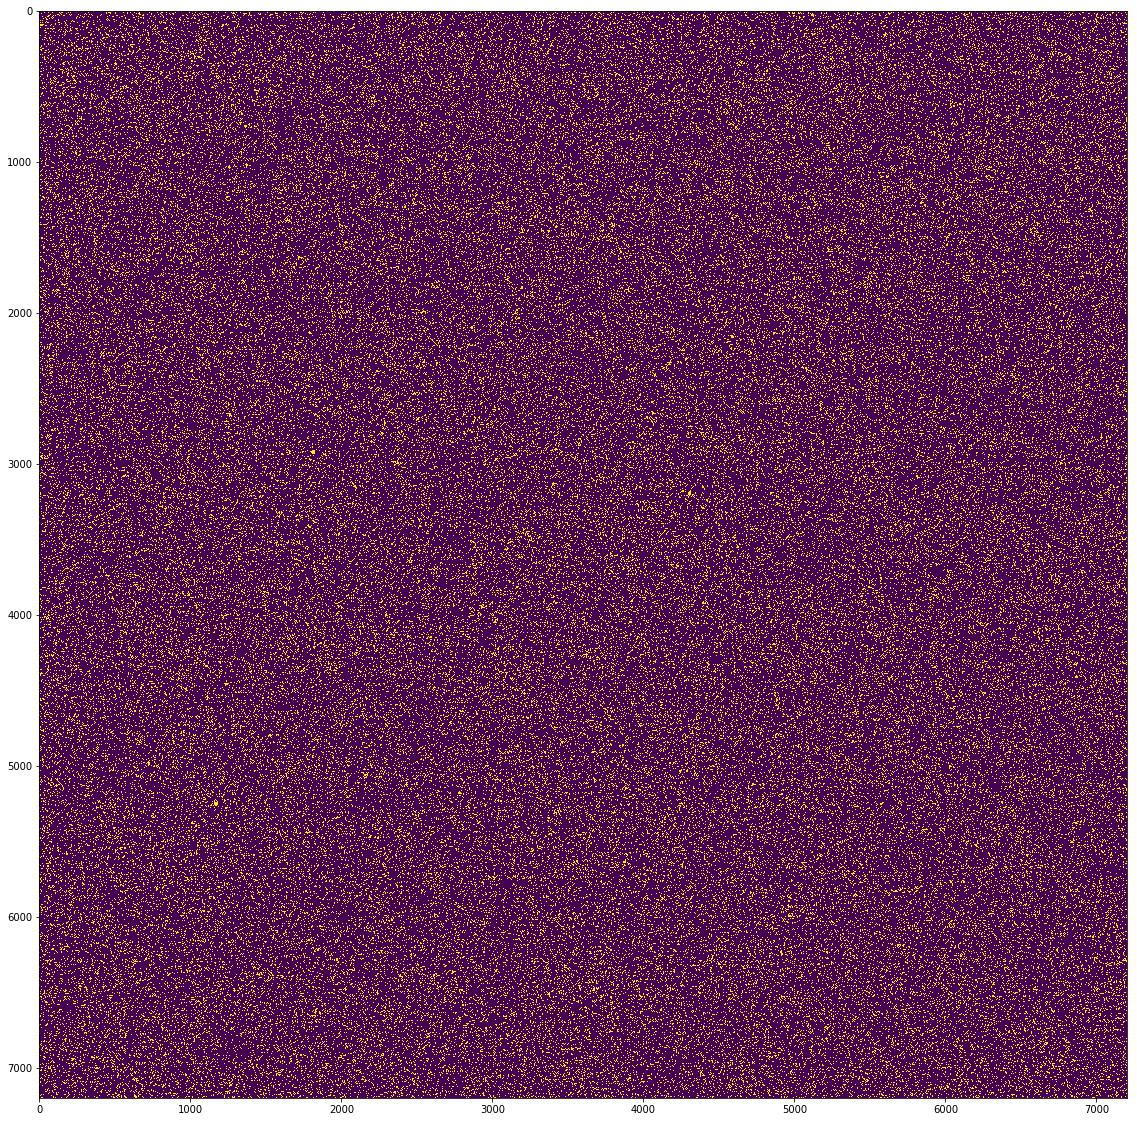

In [74]:
plt.figure(figsize=[20, 20])
plt.imshow(img>0)